<a href="https://colab.research.google.com/github/Avensuron/-/blob/main/26_12_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем нужные библиотеки

In [45]:
from shutil import copyfile
copyfile(src = "/content/input/attention.py", dst = "/content/working/attention.py")

'/content/working/attention.py'

In [46]:
pip install keras-self-attention

In [47]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
from keras_self_attention import SeqSelfAttention
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Подгружаем датасет

In [48]:
data=pd.read_csv("/content/train.csv")

Удаляем повторяющиеся заголовки и нулевые значения

In [49]:
data.drop_duplicates(subset=['Text'],inplace=True)#удаление дубликатов
data.dropna(axis=0,inplace=True)

Информация о типах данных и форме набора данных

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118731 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      118731 non-null  int64 
 1   Header  118731 non-null  object
 2   Text    118731 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


Словарь для расширения сокращений

In [51]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

Удаляем стоп-слова

In [52]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
stop_words = set(stopwords.words('english'))

Функция очистки

In [54]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #удаление короткого слова
            long_words.append(i)
    return (" ".join(long_words)).strip()

Чистим текст новостей и отображаем первые 5 результатов

In [55]:

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))
cleaned_text[:5]

['reuters short sellers wall street dwindling band ultra cynics seeing green',
 'reuters private investment firm carlyle group reputation making well timed occasionally controversial plays defense industry quietly placed bets another part market',
 'reuters soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums',
 'reuters authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil official said saturday',
 'afp tearaway world oil prices toppling records straining wallets present new economic menace barely three months us presidential elections']

Чистим заголовки и отображаем 10 примеров

In [56]:
#вызов функции
cleaned_summary = []
for t in data['Header']:
    cleaned_summary.append(text_cleaner(t,1))
cleaned_summary[:10]

['wall st bears claw back into the black',
 'carlyle looks toward commercial aerospace',
 'oil and economy cloud stocks outlook',
 'iraq halts oil exports from main southern pipeline',
 'oil prices soar to all time record posing new menace to us economy',
 'stocks end up but near year lows',
 'money funds fell in latest week',
 'fed minutes show dissent over inflation',
 'safety net',
 'wall st bears claw back into the black']

Добавляем колонки для очищенных данных

In [57]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

Удаляем пустые строки

In [58]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

Визуализация распределения текста и сводной информации

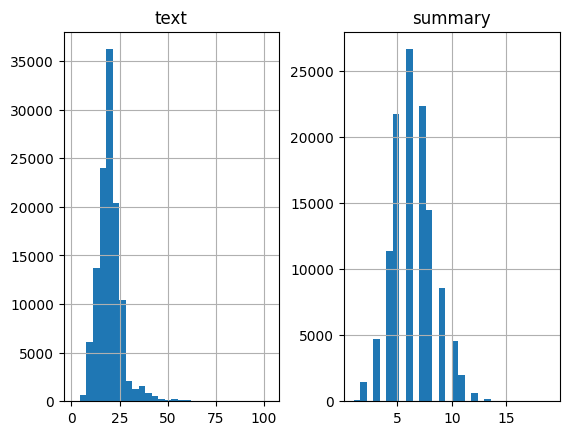

In [59]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# заполнить списки длиной предложений
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [60]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9757934101475642


In [61]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=80):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9995788693484267


In [62]:
max_text_len=80
max_summary_len=81

Убираем отклонения

In [63]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

Добавление токенов в начало и конец сводки (sostok - начало токена сводки, eostok - конец токена сводки)

In [64]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [65]:
for i in range(5):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: reuters short sellers wall street dwindling band ultra cynics seeing green
Summary: sostok wall st bears claw back into the black eostok


Review: reuters private investment firm carlyle group reputation making well timed occasionally controversial plays defense industry quietly placed bets another part market
Summary: sostok carlyle looks toward commercial aerospace eostok


Review: reuters soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums
Summary: sostok oil and economy cloud stocks outlook eostok


Review: reuters authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil official said saturday
Summary: sostok iraq halts oil exports from main southern pipeline eostok


Review: afp tearaway world oil prices toppling records straining wallets present new economic menace barely three months us presidential elections
Summary: sostok oil price

Разделение обучающего и тестового набора

In [66]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.05,random_state=0,shuffle=True)

Подготавливаем токенизатор для текста новостей

In [67]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

Подсчет количества редких и распространенных слов

In [68]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% редких слов в словарном запасе:",(cnt/tot_cnt)*100)
print("Общий охват редких словs:",(freq/tot_freq)*100)

% редких слов в словарном запасе: 54.130992766499745
Общий охват редких словs: 2.030839642587341


Определение токенизатора с наиболее распространенными словами

In [69]:
#подготовить токенизатор для обзоров обучающих данных
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#конвертировать текстовые последовательности в целочисленные последовательности
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#заполнение нулями до максимальной длины
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#размер словаря (+1 за токен заполнения)
x_voc   =  x_tokenizer.num_words + 1

In [70]:
x_voc

25556

Подгатавливаем токенизатор для заголовков

In [71]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

Количество редких и распространенных слов в сводках

In [72]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% редких слов в словарном запасе:",(cnt/tot_cnt)*100)
print("Общий охват редких слов:",(freq/tot_freq)*100)

% редких слов в словарном запасе: 66.09087733782111
Общий охват редких слов: 4.254175847307477


Подгатавливаем токенизатор для наиболее распространенных слов

In [73]:
#подготовить токенизатор для сводок по обучающим данным
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#конвертировать текстовые последовательности в целочисленные последовательности
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#заполнение нулями до максимальной длины
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#размер словарного запаса
y_voc  =   y_tokenizer.num_words +1

Проверяем что количество слов стартового токена равно длине обучающих данных

In [74]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(112744, 112744)

Удаление строк, содержащих только токены START и END

In [75]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [76]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

Построение модели, определение слоев LSTM, кодировщика и декодера.

In [77]:
from keras import backend as K
from tensorflow.keras.layers import Attention
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 100)              2555600   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 80, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [78]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Мониторинг потерь при валидации

In [79]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2),
      ModelCheckpoint('./MyModel_tf',monitor='val_loss', verbose=1,
                      save_best_only=True, mode='min', save_weights_only = False)]

Обучаем модель на пакете размером 128 и проверяем ее на 10% набора данных

In [80]:
history=model.fit([x_tr,y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=3,callbacks=[es],batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/3
 95/881 [==>...........................] - ETA: 4:17:06 - loss: 1.1280

KeyboardInterrupt: ignored

In [40]:
# serialize model to JSON
model_json = model.to_json()
with open("summary.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("summary.h5")
print("Saved model to disk")

Saved model to disk


Понимание поведения модели со временем

In [41]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: ignored

Преобразовываем индекс в слова для словаря

In [41]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

Настройка вывода для кодера и декодера

In [42]:
# Закодируйте входную последовательность, чтобы получить вектор признаков
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Настройка декодера
# Тензоры ниже будут содержать состояния предыдущего временного шага
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# вложения последовательности декодера
dec_emb2= dec_emb_layer(decoder_inputs)
# Чтобы предсказать следующее слово в последовательности, установим начальные состояния в состояния предыдущего временного шага.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#вывод о внимании
attn_out_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Плотный слой softmax для генерации вероятного расстояния. сверх целевого словарного запаса
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Окончательная модель декодера
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Определение функции для реализации процесса вывода

In [43]:
def decode_sequence(input_seq):
    # Закодируйте вход как векторы состояния.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Сгенерируйте пустую целевую последовательность длины 1.
    target_seq = np.zeros((1,1))

    # Заполните первое слово целевой последовательности начальным словом.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Образец токена
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Условие выхода: либо достичь максимальной длины, либо найти стоп-слово.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Обновите целевую последовательность (длиной 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Обновить внутренние состояния
        e_h, e_c = h, c

    return decoded_sentence

Преобразование целочисленной последовательности в последовательность слов

In [44]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [44]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    #print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

NameError: ignored

Отображение некоторых сводок, сгенерированных моделью